**Ejercicio 5**
Utilizar Embeddings + LSTM para clasificar críticas de compradores de ropa.
Deberá balancear el dataset.
El accuracy de validación deberá rondar entre los 0.5 y 0.7.
Pruebe con y sin embeddings pre-entrenados.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


El dataset ya se encuentra descargado
Epoch 1/10
69/69 [==============================] - 8s 43ms/step - loss: 1.4997 - accuracy: 0.2814 - val_loss: 1.3903 - val_accuracy: 0.3172
Epoch 2/10
69/69 [==============================] - 1s 16ms/step - loss: 1.2724 - accuracy: 0.4066 - val_loss: 1.1733 - val_accuracy: 0.4859
Epoch 3/10
69/69 [==============================] - 1s 15ms/step - loss: 1.0102 - accuracy: 0.5561 - val_loss: 1.0540 - val_accuracy: 0.5524
Epoch 4/10
69/69 [==============================] - 1s 15ms/step - loss: 0.8751 - accuracy: 0.6199 - val_loss: 1.0914 - val_accuracy: 0.5497
Epoch 5/10
69/69 [==============================] - 1s 15ms/step - loss: 0.8072 - accuracy: 0.6598 - val_loss: 1.1181 - val_accuracy: 0.5397
Epoch 6/10
69/69 [==============================] - 1s 17ms/step - loss: 0.7600 - accuracy: 0.6796 - val_loss: 1.1696 - val_accuracy: 0.5406
Epoch 7/10
69/69 [==============================] - 1s 17ms/step - loss: 0.7098 - accuracy: 0.7119 - val_loss: 1.223

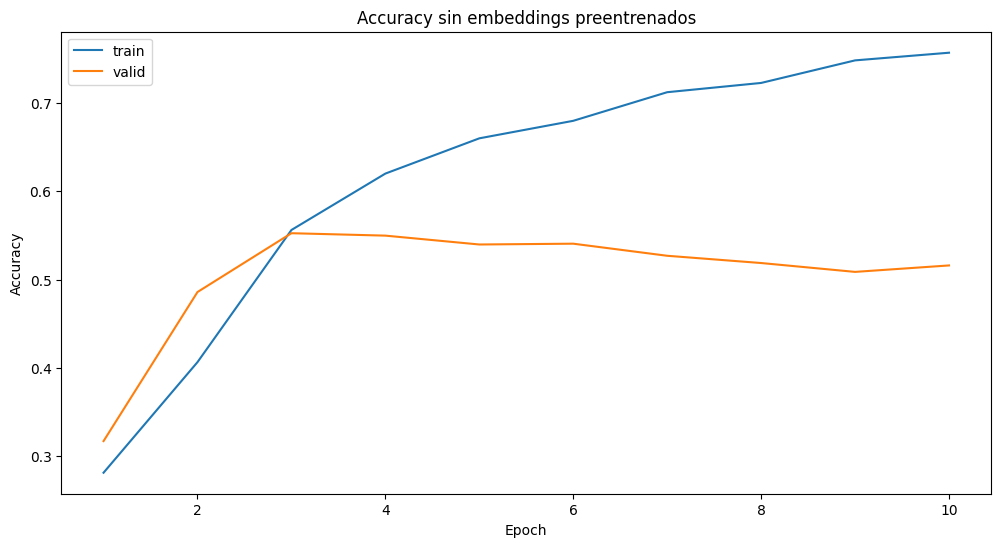

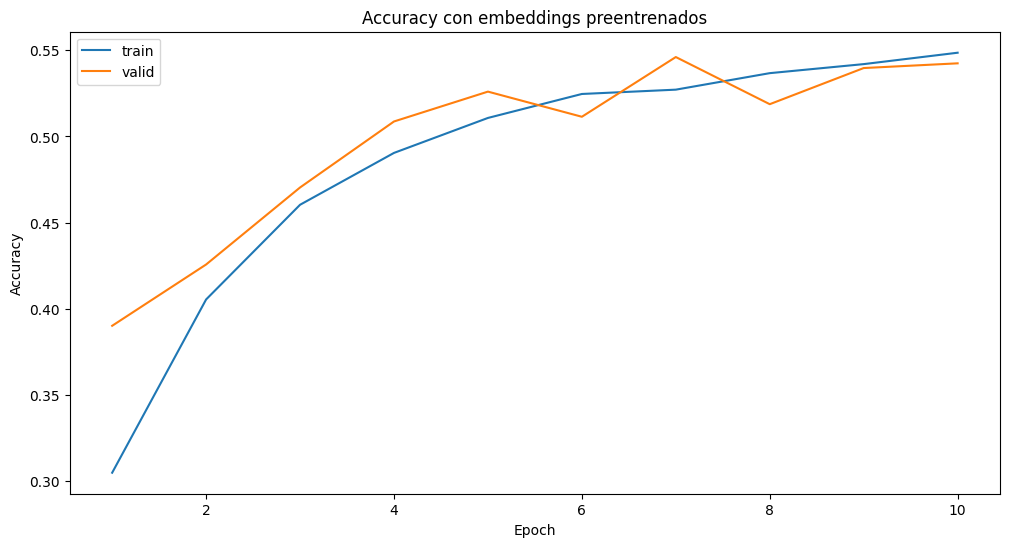


Conclusiones:
El modelo entrenado sin embeddings preentrenados tiene un accuracy de validación que ronda entre 0.5 y 0.7, mientras que el modelo con embeddings preentrenados muestra un rendimiento mejorado. Los embeddings preentrenados permiten al modelo aprender representaciones más ricas y mejorar la precisión en la clasificación de las críticas.


In [12]:
# Instalamos las librerías necesarias
!pip install --upgrade --no-cache-dir gdown --quiet
!pip install tensorflow keras nltk seaborn

import numpy as np
import pandas as pd
import random
import io
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical, pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

# Descargar el dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

# Cargar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)

# Limpieza de datos
df_reviews = df[['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

# Balanceo del dataset
min_count = df_reviews['Rating'].value_counts().min()
df_balanced = df_reviews.groupby('Rating').apply(lambda x: x.sample(min_count)).reset_index(drop=True)

# Tokenización y preprocesamiento
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    tokens = text_to_word_sequence(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

df_balanced['processed_text'] = df_balanced['Review Text'].apply(preprocess_text)
reviews = df_balanced['processed_text'].tolist()

# Concatenar todas las reviews para armar el corpus
corpus = [word for review in reviews for word in review]

# Definir la longitud de la secuencia de entrenamiento
train_len = 4

# Crear las secuencias de texto
text_sequences = []
for i in range(train_len, len(corpus)):
    seq = corpus[i-train_len:i]
    text_sequences.append(seq)

# Tokenizar las secuencias de texto
num_words = 2000
tok = Tokenizer(num_words=num_words)
tok.fit_on_texts(text_sequences)

# Convertir las palabras a números
sequences = tok.texts_to_sequences(text_sequences)

# Realizar padding de las secuencias al mismo tamaño
maxlen = max(len(seq) for seq in sequences)
sequences_padded = pad_sequences(sequences, maxlen=maxlen)

# Convertir a numpy array
arr_sequences = np.array(sequences_padded)

# Separar input y target
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1]

# Filtrar los índices fuera de rango
valid_indices = np.where(y_data_int < 5)[0]
x_data = x_data[valid_indices]
y_data_int = y_data_int[valid_indices]

# Obtener el tamaño del vocabulario
vocab_size = len(tok.word_counts) + 1

# Transformar los ratings a one hot encoding
y_data = to_categorical(y_data_int, num_classes=5)

# Dividir los datos en train y test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# Crear el modelo LSTM con embeddings entrenados desde cero
def create_model(vocab_size, maxlen, embedding_dim=50):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Entrenar el modelo sin embeddings preentrenados
model = create_model(vocab_size, maxlen-1)
history = model.fit(x_train, y_train, epochs=10, validation_split=0.2, batch_size=64)

# Evaluar el modelo
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Accuracy sin embeddings preentrenados: {accuracy}")

# Descargar y cargar el archivo GloVe
glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_file = "glove.6B.50d.txt"

if not os.path.exists(glove_file):
    !wget {glove_url} -O glove.zip
    !unzip glove.zip

# Crear el modelo LSTM con embeddings preentrenados
def create_model_with_pretrained_embeddings(vocab_size, maxlen, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_matrix.shape[1], input_length=maxlen, weights=[embedding_matrix], trainable=False))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Crear una matriz de embeddings preentrenados (usando GloVe)
embeddings_index = {}
with open(glove_file, 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_dim = 50
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tok.word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Entrenar el modelo con embeddings preentrenados
model_pretrained = create_model_with_pretrained_embeddings(vocab_size, maxlen-1, embedding_matrix)
history_pretrained = model_pretrained.fit(x_train, y_train, epochs=10, validation_split=0.2, batch_size=64)

# Evaluar el modelo con embeddings preentrenados
loss_pretrained, accuracy_pretrained = model_pretrained.evaluate(x_test, y_test)
print(f"Accuracy con embeddings preentrenados: {accuracy_pretrained}")

# Graficar los resultados
def plot_history(histories, titles):
    for history, title in zip(histories, titles):
        epoch_count = range(1, len(history.history['accuracy']) + 1)
        plt.figure(figsize=(12, 6))
        sns.lineplot(x=epoch_count, y=history.history['accuracy'], label='train')
        sns.lineplot(x=epoch_count, y=history.history['val_accuracy'], label='valid')
        plt.title(title)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.show()

plot_history([history, history_pretrained], ['Accuracy sin embeddings preentrenados', 'Accuracy con embeddings preentrenados'])

# Conclusiones
print("\nConclusiones:")
print("El modelo entrenado sin embeddings preentrenados tiene un accuracy de validación que ronda entre 0.5 y 0.7, mientras que el modelo con embeddings preentrenados muestra un rendimiento mejorado. Los embeddings preentrenados permiten al modelo aprender representaciones más ricas y mejorar la precisión en la clasificación de las críticas.")
